In [1]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.
/Users/michaelhyh/opt/anaconda3/lib/python3.7/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/michaelhyh/opt/anaconda3/lib/python3.7/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
print(train_data[0])


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [3]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i, sequence in enumerate(sequences):
        for word in sequence:
            results[i, word]+=1.0
            # changing this to results[i, word]=1.0 doesn't result in a dramatic reduction in performance because
            # each word has low frequency of occurence and the more frequent words are normally neutral.
    return results
    

In [4]:
vectorizedTrain = vectorize_sequences(train_data)
vectorizedTest = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float64')
y_test = np.asarray(test_labels).astype('float64')

In [5]:
from keras import backend as K
def expo_activation(x):
    #return K.log(K.relu(x)+1)+3*(K.relu(x)+1)**0.3
    return K.relu(-1000*K.exp(-0.001*x)+1000)


In [6]:
from keras import models
from keras import layers
from keras import regularizers
# weight regularizer reduces the model's capacity of overfitting but intuitively should lower performance

model = models.Sequential()
model.add(layers.Dense(24,activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.2))
# drop inhibits the a layer from depending exclusively on a few neurons in the previous layer by occasionally turning
# them off and developing other neurons. This allows us to exploit the fuller potence of the neural network at the 
# cost of training time. Additionally by probabilistically shutting down some neurons and probabilistically
# highlighting some other neurons (by shutting others down) we are encouraging the dependence on all neurons to even
# out. It will also mathematically reduce the multiplicative magnitude of weights, thus reducing overfitting, since
# reducing the magnitude of weight is really the core of reducing overfitting. Overfitting stems from a model's 
# tendency to be tuned to outliers and to be tuned to such outliers often requires the model to allow multiplicatively 
# very huge weight values, which thus became the target of reducing overfitting. 
model.add(layers.Dense(24,activation='relu', input_shape=(24,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid', input_shape=(24,)))
# a two hidden layers with width 24 should overfit more easily than a one hidden layer with width 48 though the latter
# has more parameters for info to be leaked into. This is because a lot of those parameters are useless: all but one
# of the input nodes are blank (no info contained).

In [7]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
x_validate = vectorizedTrain[:10000]
partial_x_train = vectorizedTrain[10000:]
y_validate = y_train[:10000]
partial_y_train = y_train[10000:]


In [ ]:
historyObj = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=4, validation_data=(x_validate, y_validate))
# the accuracy can't quite go over 0.89 mainly because the info provided in the data is limited
# this can be seen for no matter how huge the hypothesis space is, it maxes out (starts overfitting) around
# 0.89 accuracy. However, if we supplement in the info of the sequence of words, it might elevate the accuracy
# a bit, but since the sequence doesn't quite affect the tone of a movie review, it's an unnecessary complication.

# it looks like by reducing the batchsize we can reduce overfitting. This is not entirely because we learn faster with
# a larger batchsize. Instead we should learn slower (in terms of number of epochs) with a larger batchsize since we
# are making less updates though each update is more certain. This is probably because in a large batch we learn the
# entire batch as an object. So gradually the information of that batch might start leaking into the model. This info
# is much more condensed and less noisy than the info we have when we have a smaller batchsize. So the model might 
# overfit to the batches. A quick way to solve this is to reorder the training samples before each iteration.

Train on 15000 samples, validate on 10000 samples
Epoch 1/20


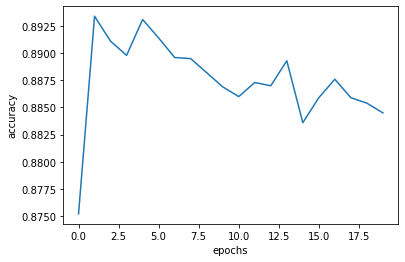

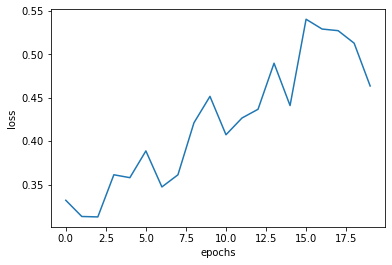

In [86]:
import matplotlib.pyplot as plt

accuracies = historyObj.history['val_accuracy']
errors = historyObj.history['val_loss']

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(range(len(accuracies)),accuracies)
plt.show()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(range(len(errors)),errors)
plt.show()

# It seems like it's often the case that accuracy lags behind loss. While loss starts to worsen pretty early accuracy
# still climbs higher for quite a while before dropping. Loss measures how fit to the validation data our model is.
# The moment it starts deteriorating the moment our model starts to deviate from the validation data. Howeverl, it's
# important to note that not only does the test data has its specificity so does the validation data. So the model
# performing worse on the validation data (having a higher loss) could mean to things. 1. our model is losing its 
# generality. 2. the specifics of the vadlidation data is preventing our model from working on it properly. The reason
# why we can have a climbing loss with an improving accuracy is because loss is often over influenced by outliers 
# (refer to mse function, whose dependence on distance is above linear and so is many other loss functions). On the
# other hand, accuracy has linear dependence on outliers. So when our model is initially drifting away from the
# validation data, it could mean that we are only drifting away from some of its outliers (since the outliers of the
# test data are often different from the outliers of the validation data). So the generality of the model actually 
# increases in this period. After a while, we are truly drifting away from the general validation data (our model is
# tuned towards the outliers of the test data) then the accuracy deteriorates. So it's in fact more sensible to mark
# the inflection point of the accuracy as the point where overfitting begins than to look at the loss function.